In [59]:
import tensorflow as tf
import nibabel as nb
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from numpy.random import default_rng

# Objetivos 

 - Cambiar b_size por el batch size normal (linea 7)
 - Abrir todas las imagenes con el mismo proceso (preferible pero opcional)
 - Dejar el dataset como tf dataset (importante)

## Global Asumptions

In [197]:
image_size=256
channels=1
batch_size = 10
width=200
augmentations = {'scale': 0.2 , 'brightness': 0.2}
dataset_name = '../ACV_DWI-ADC_W_MASKS.tfrecords'
modalities = ['ADC', 'DWI']
#b_size = 10


# Usefull for the dataset 
feature_description = {
    'patient':tf.io.FixedLenFeature([], tf.string),
    'image_type':tf.io.FixedLenFeature([], tf.string),
    'is_mask':tf.io.FixedLenFeature([], tf.int64),
    'image_tensor':tf.io.FixedLenFeature([], tf.string),
}
def parse_example(proto):
    return tf.io.parse_single_example(proto, feature_description)

def get_feature(feature, out_type):
    return tf.io.parse_tensor(feature, out_type=out_type)

def data_to_dict(data):
    result = {}
    for key in feature_description.keys():
        if not('image_tensor' in key):
            print(key)
            print(type(data[key]))
            result[key] = np.array(data[key])
        else:
            result[key] = get_feature(data[key], tf.double)
            
def split_into_batches(data: list):
    result = []
    step = len(data)//b_size
    
    for i in range(1, len(data)):
        result.append(data[(i * step) - step: i * step])
    return result

def get_labeled_slices(tensor_image, mask):
    """
    Returns a list of slices each one with a label indicating
    whether it has lesion or not. 
    """
    # Gets the slices where there is lesion
    labels = (tf.reduce_sum(tf.reduce_sum(mask, axis=0), axis=0)).numpy()
    labels = (labels > 0).astype(int)

    # Une todas las imagenes en una sola lista acumulada
    image = tensor_image
    image = image + np.abs(image.numpy().min())
    image = image / image.numpy().max()
    image = tf.image.resize(image, (image_size, image_size))
    
    return tf.unstack(image, axis=2), np.split(labels, len(labels))

def get_paired_slices(tensor_image, mask):
    # Gets the slices where there is lesion
    mask = tf.image.resize(mask, (image_size, image_size))

    # Une todas las imagenes en una sola lista acumulada
    image = tensor_image
    image = image + np.abs(image.numpy().min())
    image = image / image.numpy().max()
    image = tf.image.resize(image, (image_size, image_size))
    
    return tf.unstack(image, axis=2), tf.unstack(mask, axis=2)

def get_labeled_dataset(data_dict):
    tensor_dict = {im_type: [] for im_type in modalities}
    label_dict = {im_type: [] for im_type in modalities}
    dataset_imgs = {im_type: None for im_type in modalities}
    dataset_labels = {im_type: None for im_type in modalities}
    count_deleted = 0
    pacientes_omitidos = []
    pacientes_aceptados = []
    
    for paciente, data in data_dict.items():
        # Verifica que tenga las mascaras para todas las modalidades
        if data.has_masks() and data.has_modalities():
            # Toma las mascaras y las suma. ASUME QUE TODAS LAS IMAGENES TIENEN EL MISMO SHAPE
            modalities_masks = data.get_merged(masks=True)
            
            for modal in data.get_modalities():
                # Obtiene una lista de slices y una lista de sus etiquetas
                #image_list, label_list = get_labeled_slices(data.get_image(modal), modalities_masks[modal])
                image_list, label_list = get_paired_slices(data.get_image(modal), modalities_masks[modal])
                
                # Se agregan los slices y las etiquetas al consolidado
                tensor_dict[modal] += image_list
                label_dict[modal] += label_list
                pacientes_aceptados.append(paciente)
                
        else: 
            pacientes_omitidos.append(paciente)
            count_deleted += 1
            continue
    
    pacientes_omitidos = set(pacientes_omitidos)
    pacientes_aceptados = set(pacientes_aceptados)
    print(f'Cantidad de pacientes validados: {len(pacientes_aceptados)}')
    print(f'Cantidad de pacientes ignorados: {len(pacientes_omitidos)}')
    #print(f'Number of Ignored images: {count_deleted}')
    
    print('\n')
    print(f'Pacientes Validados: ', end='')
    for p in pacientes_aceptados:
        print(paciente, end='; ')
    
    print('\n')
    print(f'Pacientes Ignorados: ', end='')
    for p in pacientes_omitidos:
        print(p, end='; ')
    
    print('\n')
    # Crea los datasets
    for modal in tensor_dict.keys():
        temp = tf.data.Dataset.from_tensor_slices(tensor_dict[modal]).batch(batch_size)
        dataset_imgs[modal] = temp.map(lambda x: x[..., tf.newaxis])
        
        ################## ELIMINAR CUANDO SE USEN LAS LABELS NORMALES Y NO LAS IMAGENES
        temp_label = tf.data.Dataset.from_tensor_slices(label_dict[modal]).batch(batch_size)
        dataset_labels[modal] = temp_label.map(lambda msk: tf.expand_dims(msk, axis=-1))
        
        print(f'Cantidad de mascaras para {modal}: {np.array(label_dict[modal]).sum()}')
        
    return dataset_imgs, dataset_labels

class DataSegment:
    def __init__(self, image_types:list):
        """
        images_types is expected to be a list of the different medical images types
        in UPPER CASE  
        Example: image_types: ['ADC', 'DWI']
        """
        self.patient_code = None
        self.masks = {img_type: [] for img_type in image_types}
        self.images = {img_type: [] for img_type in image_types}
    
    def reduce_to_3dims(self, image):
        dims = len(image.shape)
        if dims <= 3:
            return image
        
        result = image
        # Suma los ejes finales hasta que solo queden 3 ejes
        while(dims > 3):
            result = tf.math.reduce_sum(result, axis=-1)
            dims -= 1
        return result
        
    def set_image(self, image_dict):
        im_type = image_dict['image_type']
        
        if image_dict['is_mask'] == '1':
            self.masks[im_type].append(image_dict['image_tensor'])
        else:
            self.images[im_type].append(image_dict['image_tensor'])
    
    def get_image(self, image_type):
        if len(self.images[image_type]) > 1:
            print(f'WARNING: {image_type} modality for patient {self.patient_code} has more than 1 measure.')
            print('Returning only the first image.')
            
        
        return self.reduce_to_3dims(self.images[image_type][0])
            
    def get_merged(self, masks=False):
        """
        Returns a dict of the images, if for one image type there are
        several images it adds them to return a single image per
        image type
        
        masks: Indicates whether to perform the operation over the 
        masks or the images.
        """
        if masks:
            to_iterate = self.masks.copy()
        else:
            to_iterate = self.images.copy()
            
        merged = {}
        for img_type, img_list in to_iterate.items():
            ################# note ################
            # There are probably better ways to do it
            # using tensor operations, like sum through
            # an axis. For future improvements
            merged_img = None
            for img in img_list:
                if merged_img is None:
                    merged_img = img
                else:
                    merged_img += img
                    
            merged[img_type] = merged_img
        
        return merged
    
    def get_modalities(self):
        return list(self.images.keys())
                
    def has_masks(self):
        """
        Returns True if there is at least one mask per image
        type. Otherwise returns False.
        """
        for img_type, mask_list in self.masks.items():
            if len(mask_list) == 0:
                return False
        return True
    
    def has_modalities(self):
        """
        Returns True if there is at least one mask per image
        type. Otherwise returns False.
        """
        for img_type, image_list in self.images.items():
            if len(image_list) == 0:
                return False
        return True

## Load Dataset

## Pipeline to get pairs of slices and its class (marked/ not marked)

In [184]:
raw_data = tf.data.TFRecordDataset(dataset_name)

# Deserialize the messsages
dataset = raw_data.map(parse_example)
#dataset = dataset.map(lambda img: tf.image.resize(img, (image_size, image_size, 1)))
#dataset = dataset.map(foo)
#dataset = dataset.map(data_to_dict)

#################################################################################
# CONVERTS THE DATASET INTO A LIST OF DICTIONARIES
# Put each image 
#################################################################################
data_list = []
data_dict = {}
for data in dataset:
    temporal_dict = {}
    
    for key in feature_description.keys():
        if not('image_tensor' in key):
            # Parses the string and boolean fields as python strings
            temporal_dict[key] = str(np.array(data[key]).astype(str))
        else:
            # Parses the actual image as a tensor
            temporal_dict[key] = get_feature(data[key], tf.double)
            
    # Stores the image in a dictionary sorting it by its patient code and if it is a mask or not
    # It assumes all images are ADC SERIES
    
    patient_code = temporal_dict['patient']
    # Checks if the patient is already in the dictionary
    if not(patient_code in data_dict.keys()):
        data_dict[patient_code] = DataSegment(modalities)

    data_dict[patient_code].set_image(temporal_dict)
    

data_dict.keys()
print(f'Cantidad de pacientes pre-seleccionados: {len(data_dict.keys())}')

Cantidad de pacientes pre-seleccionados: 134


In [198]:
dataset_dict, labels_dict = get_labeled_dataset(data_dict)
adc_dataset = dataset_dict['ADC']
dwi_dataset = dataset_dict['DWI']
adc_labels = labels_dict['ADC']
dwi_labels = labels_dict['DWI']

#dataset = tf.data.Dataset.zip((adc_dataset, dwi_dataset))
#labels = tf.data.Dataset.zip((adc_labels, dwi_labels))

dataset = tf.data.Dataset.zip((adc_dataset, dwi_dataset, adc_labels, dwi_labels))

Cantidad de pacientes validados: 13
Cantidad de pacientes ignorados: 121


Pacientes Validados: ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; ACV-251; 

Pacientes Ignorados: ACV-056; ACV-005; ACV-082; ACV-237; ACV-090; ACV-051; ACV-225; ACV-140; ACV-248; ACV-245; ACV-226; ACV-180; ACV-086; ACV-133; ACV-075; ACV-006; ACV-095; ACV-244; ACV-149; ACV-044; ACV-129; ACV-132; ACV-229; ACV-142; ACV-099; ACV-230; ACV-130; ACV-155; ACV-055; ACV-019; ACV-081; ACV-021; ACV-087; ACV-190; ACV-159; ACV-108; ACV-094; ACV-046; ACV-121; ACV-057; ACV-112; ACV-241; ACV-036; ACV-104; ACV-224; ACV-166; ACV-145; ACV-105; ACV-125; ACV-184; ACV-062; ACV-172; ACV-233; ACV-065; ACV-259; ACV-179; ACV-186; ACV-002; ACV-264; ACV-031; ACV-242; ACV-054; ACV-254; ACV-162; ACV-181; ACV-249; ACV-150; ACV-176; ACV-118; ACV-053; ACV-110; ACV-251; ACV-194; ACV-238; ACV-260; ACV-073; ACV-253; ACV-256; ACV-167; ACV-122; ACV-076; ACV-032; ACV-109; ACV-074; ACV-043;

In [199]:
sample = next(iter(dataset))[0:10]
tf.shape(sample)

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  4,  10, 256, 256,   1], dtype=int32)>

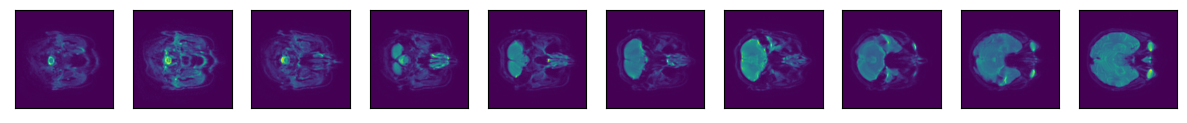

In [130]:
# Show some samples
#sample = labeled_dataset[0][0:b_size]
sample = next(iter(dwi_dataset))[0:10]

plt.figure(figsize=(15, 10))
for idx, image in enumerate(sample):
    plt.subplot(1, b_size, idx+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

plt.show()

# Augmentations:

1. Standard Normalization
2. Random scale
3. Random brightness adjust

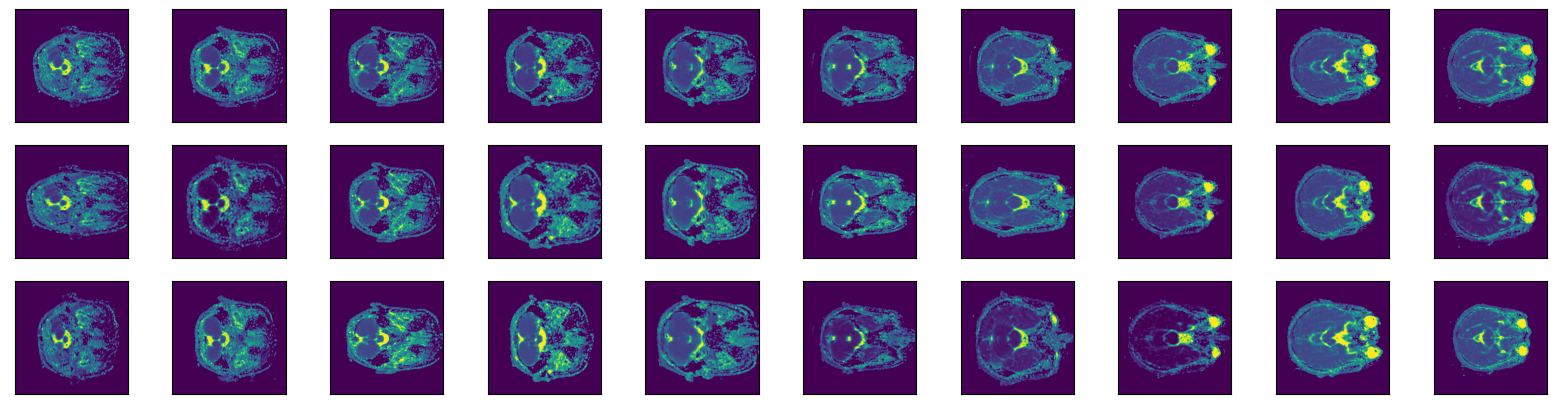

In [45]:
# Data pipeline
class Augmenter(layers.Layer):
    def __init__(self, scale, brightness, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.scale = scale
        
        # Randon generator for brightness adjust
        self.rgen = default_rng()
        
    def get_config(self):
        config = super().get_config()
        config.update({'brightness': self.brightness, 'scale': self.scale})
        return config
    
    def call(self, images, training=True):
        
        if training:
            batch_size=images.shape[0]
            width = images.shape[1]
            height = images.shape[2]
            
            #images = images/255.0
            
            # Se ecualiza la imagen y se normaliza
            #images = tfa.image.equalize(images, bins=100)
            #images = tf.image.random_brightness(images, float(self.brightness))
            #images = images / max_val
            
            """
            if not (batch_size is None):
                # Se obtienen los indices de quienes obtienen un aumento o disminucion de brillo
                positives = self.rgen.integers(low=0, high=2, size=batch_size) == 1
                negatives = positives == 0
                to_add = tf.boolean_mask(images, positives)
                to_take = tf.boolean_mask(images, negatives)
                
                brightness_var = tf.random.uniform(shape=(batch_size, 1, 1, 1), maxval=self.brightness)
                to_add = to_add + to_add * tf.boolean_mask(brightness_var, positives)
                to_take = to_take + to_take * tf.boolean_mask(brightness_var, negatives)
                
                for idx_mask, idx_real in enumerate(np.nonzero(positives)[0]):
                    images[idx_real] = to_add[idx_mask]
                    
                for idx_mask, idx_real in enumerate(np.nonzero(negatives)[0]):
                    images[idx_real] = to_take[idx_mask]
            """
            return images 

def get_augmenter(scale, brightness):
    aug = tf.keras.Sequential([
        tf.keras.Input(shape=(image_size, image_size, channels)),
        Augmenter(scale, brightness),
        layers.RandomZoom(scale, scale, fill_mode='constant'),
        layers.RandomBrightness(brightness, value_range=(0, 1))
    ])
    return aug

def augmentation_examples(num_images):    
    
    #images = next((iter(train_dataset)))[0][:num_images] # Se obtienen las imagenes
    #images = tf.stack(labeled_dataset[0][0:b_size])
    images = next(iter(dataset_imgs))[:num_images]
    augmented = get_augmenter(**augmentations)(images)
    augmented_2 = get_augmenter(**augmentations)(images)
    
    plt.figure(figsize=(20, 5))
    for idx in range(num_images):
        plt.subplot(3, num_images, idx + 1)
        plt.imshow(images[idx])
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3, num_images, idx + 1 + num_images)
        plt.imshow(augmented[idx])
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3, num_images, idx + 1 + (num_images * 2))
        plt.imshow(augmented_2[idx])
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

augmentation_examples(10)
    
    

In [7]:
rgen = default_rng()
rgen.integers(low=0, high=2, size=5)

array([1, 1, 0, 1, 0])

In [46]:
# Define the encoder architecture
def get_encoder():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(image_size, image_size, channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )
def get_projection_head():
    return tf.keras.Sequential(
    [
        tf.keras.Input(shape=(width,)),
        layers.Dense(width, activation='relu'),
        layers.Dense(width),
    ],
        name='projection_head'
    )

# Contrastive Loss

In [217]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self, temperature):
        super().__init__()
        
        # Se definen los parametros contrastivos
        self.temperature = temperature
        
        # Metricas
        self.contrastive_loss_tracker = tf.keras.metrics.Mean(name='c_loss')
        self.contrastive_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
            name='c_acc'
        )
        
        # El modulo de aumento de datos
        self.augmenter = get_augmenter(**augmentations)
        
        self.encoder = get_encoder()
        self.projection_head = get_projection_head()
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy
        ]

    def contrastive_loss(self, projections_1, projections_2, labels):
        # Se normalizan las proyecciones
        norm_1 = tf.math.l2_normalize(projections_1, axis=1)
        norm_2 = tf.math.l2_normalize(projections_2, axis=1)

        # Se hallan las similitudes del coseno
        similarities = (
            tf.matmul(norm_1, norm_2, transpose_b=True) / self.temperature
        )
        
        batch_size = tf.shape(norm_1)[0]
        #contrastive_labels = tf.range(batch_size)
        contrastive_labels = labels
        
        # Evalua la metrica de ida y de regreso
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        loss_1_2 = tf.keras.losses.binary_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = tf.keras.losses.binary_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        
        return (loss_1_2 + loss_2_1)/2
    
    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)
        
        self.contrastive_optimizer = contrastive_optimizer
        
    
    def apply_contrastive_loss(self, data, labels):
        # Se generan los aumentos
        augmented_1 = self.augmenter(data)
        augmented_2 = self.augmenter(data)
        
        # Se generan los embebidos
        features_1 = self.encoder(augmented_1, training=True)
        features_2 = self.encoder(augmented_2, training=True)
        projections_1 = self.projection_head(features_1, training=True)
        projections_2 = self.projection_head(features_2, training=True)

        contrastive_loss = self.contrastive_loss(projections_1, projections_2, labels)
        
        return contrastive_loss
        
    def train_step(self, data):
        #data = data[0]
        adc_data = data[0]
        dwi_data = data[1]
        
        adc_labl = tf.squeeze(data[2])
        dwi_labl = tf.squeeze(data[3])
        adc_labl = tf.math.reduce_sum(adc_labl, axis=-1)
        dwi_labl = tf.math.reduce_sum(dwi_labl, axis=-1)
        adc_labl = tf.math.reduce_sum(adc_labl, axis=-1)
        dwi_labl = tf.math.reduce_sum(dwi_labl, axis=-1)
        
        maxlen = tf.reduce_max(adc_labl)
        #adc_labl = tf.sequence_mask(adc_labl, maxlen=maxlen, dtype=tf.int32)        
        adc_labl = tf.where(adc_labl > maxlen, 1, 0)
        
        maxlen = tf.reduce_max(dwi_labl)
        #dwi_labl = tf.sequence_mask(dwi_labl, maxlen=maxlen, dtype=tf.int32)
        dwi_labl = tf.where(dwi_labl > maxlen, 1, 0)
        
        with tf.GradientTape() as tape:
            c_loss_0 = self.apply_contrastive_loss(adc_data, adc_labl)
            c_loss_1 = self.apply_contrastive_loss(dwi_data, dwi_labl)
            
            contrastive_loss = (c_loss_0 + c_loss_1)/2

        # Obtiene los gradientes
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        # Actualiza los pesos
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )

        self.contrastive_loss_tracker.update_state(contrastive_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    
    def test_step(self, data):
        # Seems a little lonely around here, doesn't it?
        pass
        

In [218]:
baseline = ContrastiveModel(1)
baseline.compile(
    contrastive_optimizer=tf.keras.optimizers.Adam()
)
num_epochs = 5
#history = baseline.fit(train_dataset, epochs=num_epochs)
#history = baseline.fit(dataset, labels, epochs=num_epochs)
history = baseline.fit(dataset, epochs=num_epochs)

Epoch 1/5


33/33 [==============================] - 28s 483ms/step - c_loss: 0.8917 - c_acc: 0.0690
Epoch 2/5
33/33 [==============================] - 16s 482ms/step - c_loss: 0.8032 - c_acc: 0.0997
Epoch 3/5
33/33 [==============================] - 16s 485ms/step - c_loss: 0.7817 - c_acc: 0.1273
Epoch 4/5
33/33 [==============================] - 16s 481ms/step - c_loss: 0.7621 - c_acc: 0.0966
Epoch 5/5
33/33 [==============================] - 16s 477ms/step - c_loss: 0.7545 - c_acc: 0.0844


In [220]:
print(history)

TypeError: 'History' object is not subscriptable